In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# The helper file below brings functions created in previous tutorials
from libs.helper_09_tutorial import *

In [52]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

In [820]:
# "states" will be the output of Psi from our custom "simulate" function
def expectation(operator, states):
    operator_matrix = operator.full()
    operator_expect = np.zeros(states.shape[1], dtype=complex)
    for i in range(0,shape(states)[1]):
        e = np.conj(states[:,i])@ (operator_matrix @ states[:,i])
        operator_expect[i] = e
    return operator_expect

In [1149]:
def make_operators(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator
    sigm1 = tensor(qeye(max_bosons+1), sigmam(), qeye(2))
    sigm2 = tensor(qeye(max_bosons+1), qeye(2), sigmam())
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 
    damping         = -1j*(1-sz1)*(1-sz2)/4
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
    
    two_state_1     = two_state_1.extract_states(p)
    two_state_2     = two_state_2.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction_1   = interaction_1.extract_states(p)
    interaction_2   = interaction_2.extract_states(p)
    P               = P.extract_states(p)
    damping         = damping.extract_states(p)
    sigm1 = sigm1.extract_states(p)
    sigm2 = sigm2.extract_states(p)
    
    nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, damping, sigm1, sigm2, nmm_list

In [1150]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1151]:
H

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[ 3.          0.          0.          0.          0.          0.1
   0.1         0.          0.          0.          0.          0.        ]
 [ 0.          0.5         0.          0.          0.1         0.
   0.          0.1         0.          0.          0.          0.        ]
 [ 0.          0.          0.5         0.          0.1         0.
   0.          0.1         0.          0.          0.          0.        ]
 [ 0.          0.          0.         -2.          0.          0.1
   0.1         0.          0.          0.          0.          0.        ]
 [ 0.          0.1         0.1         0.          4.          0.
   0.          0.          0.          0.14142136  0.14142136  0.        ]
 [ 0.1         0.          0.          0.1         0.          1.5
   0.          0.          0.14142136  0.          0.          0.14142136]
 [ 0.1         0.          0.          0.1         0.    

In [1152]:
damping

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j

In [1153]:
omega = 1

In [1154]:
U = 0.1

In [1155]:
max_bosons = 2

In [1156]:
parity = 0

In [1157]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, damping, sigm1, sigm2, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [1158]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

In [989]:
H = 2.5*two_state_1 + 2.5*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2 + 1*damping

In [990]:
H

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 3.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  1.        +0.j  1.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.5       +0.j  0.        +0.j  0.        +0.j
   1.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.5       +0.j  0.        +0.j
   1.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -2.        -1.j
   0.        +0.j  1.        +0.j  1.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  1.        +0.j  0.        +0.j
   4.        +0.j  0.        +0.j  0.      

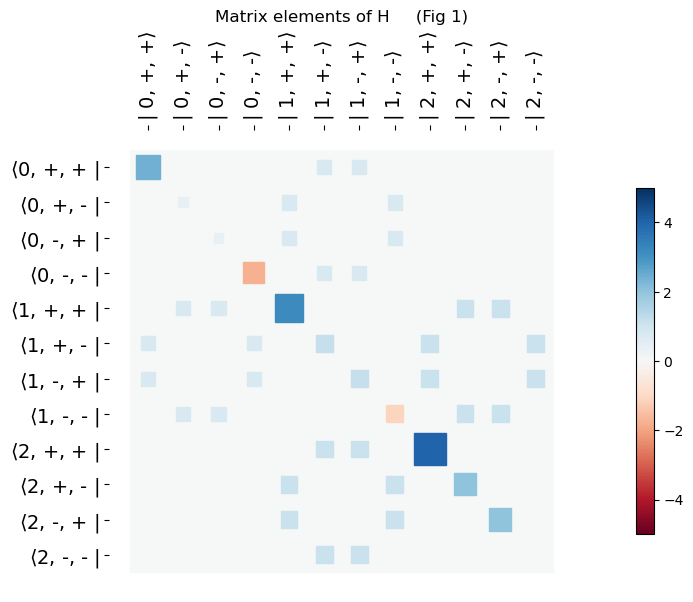

In [991]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [1206]:
# deltaE = 10
# omega = 0.1
# U = 0.01


deltaE = 2.5
omega = 1
U = 0.01



In [1218]:
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2

In [1219]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1220]:
psi0 = basis(len(nmm_list), 5)
times = np.linspace(0.0, 100000.0, 10000)
P, psi, evals, ekets = simulate(H, psi0, times)

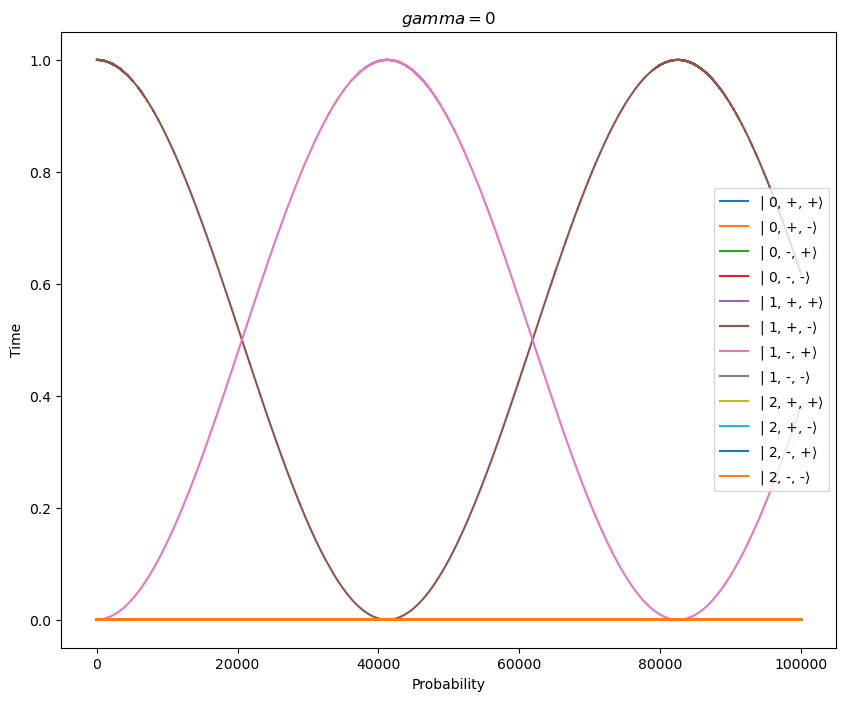

In [1223]:
plot_sim(times, P, ket_labels)
plt.title(f"$gamma = 0$");

In [997]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1224]:
gamma = 0.100

In [1225]:
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping

In [1226]:
psi0 = basis(len(nmm_list), 5)
times = np.linspace(0.0, 100000, 10000)
P, psi, evals, ekets = simulate(H, psi0, times)

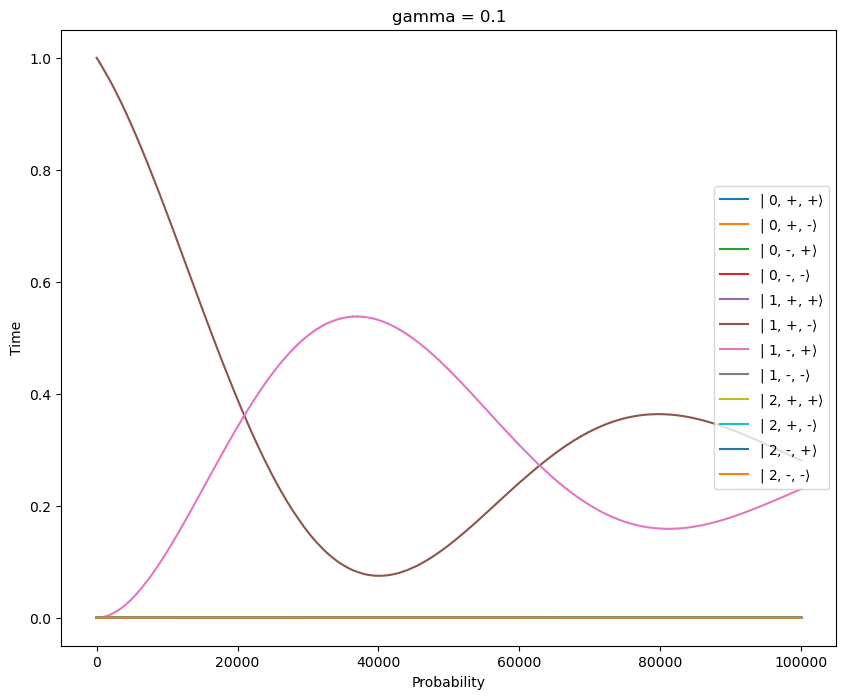

In [1228]:
plot_sim(times, P, ket_labels)
plt.title(f"gamma = 0.1");

In [1318]:
gamma = 100000000

In [1341]:
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping

In [1342]:
psi0 = basis(len(nmm_list), 5)
times = np.linspace(0.0, 1000000, 10000)
P, psi, evals, ekets = simulate(H, psi0, times)

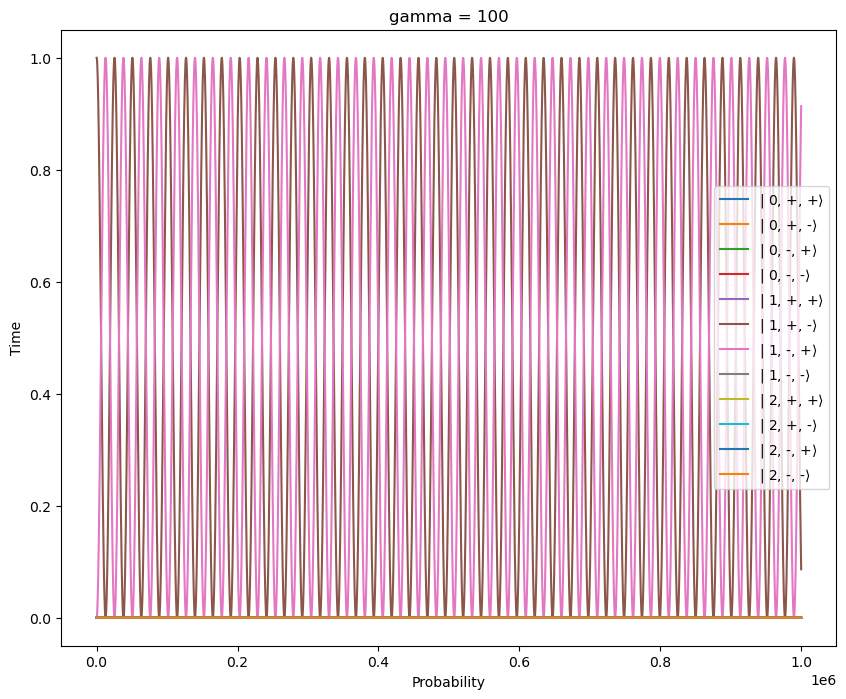

In [1343]:
plot_sim(times, P, ket_labels)
plt.title(f"gamma = 100");

In [1322]:
num_1 = expectation(two_state_1 + 1/2, psi)
num_2 = expectation(two_state_2 + 1/2, psi)

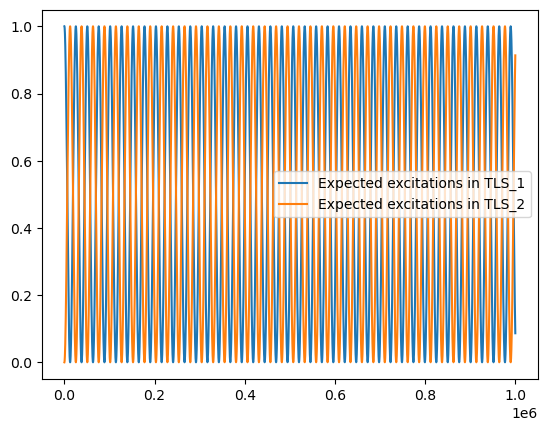

In [1323]:
plt.plot(times, num_1, label="Expected excitations in TLS_1")
plt.plot(times, num_2, label="Expected excitations in TLS_2")
plt.legend()
plt.show()

In [1324]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1346]:
psi0 = basis(len(nmm_list), 3)
times = np.linspace(0.0, 400000000, 100000)
P, psi, evals, ekets = simulate(H, psi0, times)

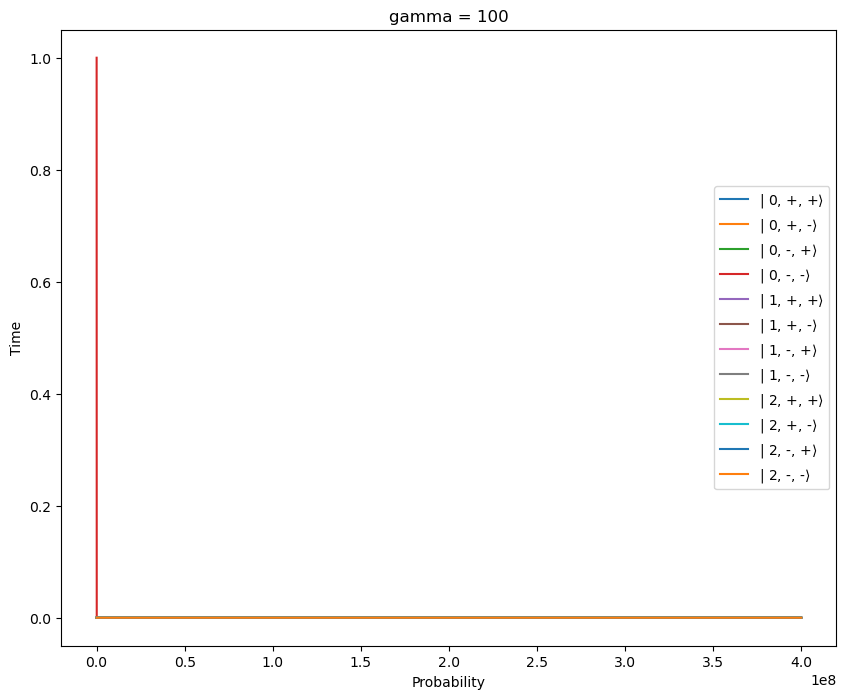

In [1347]:
plot_sim(times, P, ket_labels)
plt.title(f"gamma = 100");

In [1186]:
times = np.linspace(0.0, 700000.0, 1000000)

In [895]:
result = sesolve(H, psi0, times, [two_state_1 + 1/2,two_state_2 + 1/2])

Text(0.5, 0, 'Time')

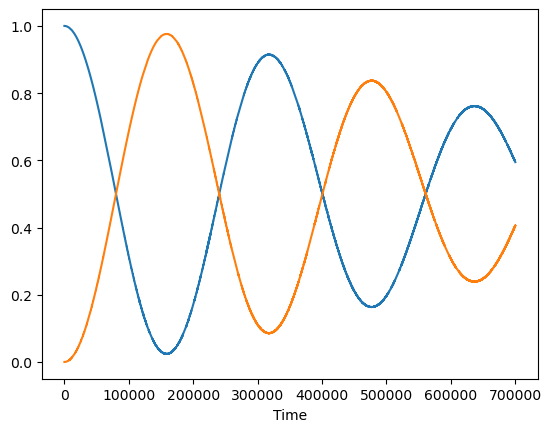

In [896]:
plt.plot(times, result.expect[0], label="Expected TLS_1")
plt.plot(times, result.expect[1], label="Expected TLS_2")
plt.xlabel("Time")

In [926]:
opts = Options(normalize_output=False)
projection_operators = [basis(len(nmm_list), i) * basis(len(nmm_list), i).dag() for i in range(len(nmm_list))]
result = sesolve(H, psi0, times, projection_operators,options=opts)

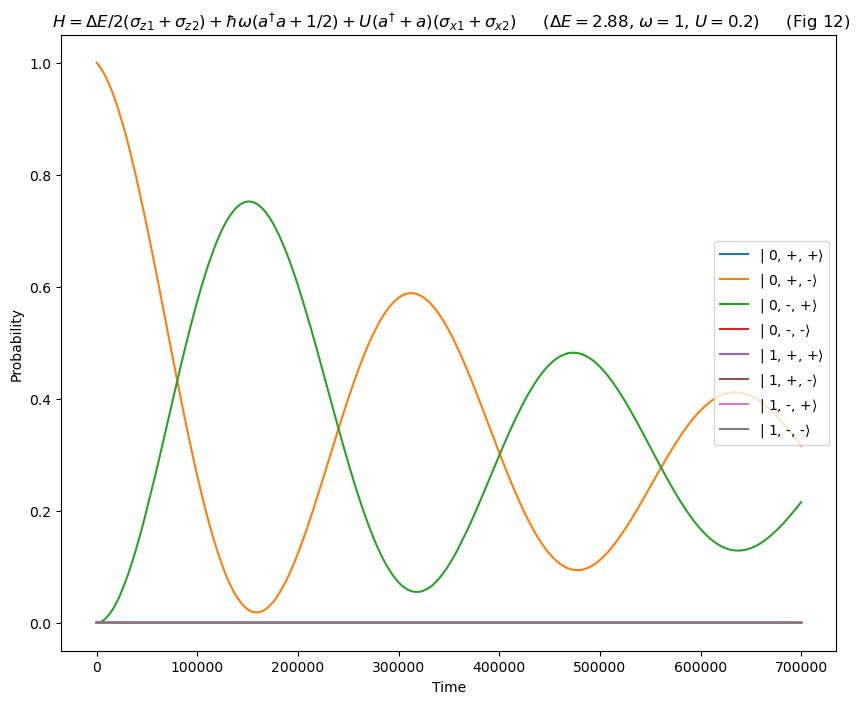

In [927]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 12)")
plt.show();

In [1159]:
deltaE = 2.5
omega = 1
U = 0.1

In [1160]:
gamma = 200

In [1161]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1162]:
psi0 = basis(len(nmm_list), 5)

In [1176]:
times = np.linspace(0.0, 3000.0, 100)

In [1177]:
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2

In [1178]:
data = mcsolve(H, psi0, times, [np.sqrt(100) * sigm1*sigm2], e_ops=[two_state_1 + 1/2,two_state_2 + 1/2])

10.0%. Run time:  32.00s. Est. time left: 00:00:04:47
20.0%. Run time:  61.28s. Est. time left: 00:00:04:05
30.0%. Run time:  92.92s. Est. time left: 00:00:03:36
40.0%. Run time: 125.68s. Est. time left: 00:00:03:08
50.0%. Run time: 159.93s. Est. time left: 00:00:02:39
60.0%. Run time: 191.20s. Est. time left: 00:00:02:07
70.0%. Run time: 222.41s. Est. time left: 00:00:01:35
80.0%. Run time: 254.71s. Est. time left: 00:00:01:03
90.0%. Run time: 288.01s. Est. time left: 00:00:00:32
100.0%. Run time: 318.54s. Est. time left: 00:00:00:00
Total run time: 318.55s


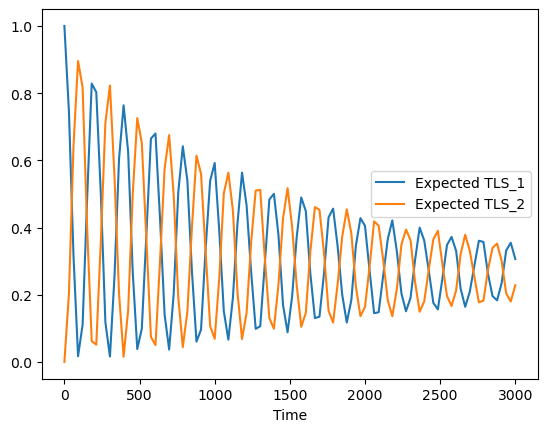

In [1180]:
plt.plot(times, data.expect[0], label="Expected TLS_1")
plt.plot(times, data.expect[1], label="Expected TLS_2")
plt.xlabel("Time")
plt.legend(loc="right")

In [1203]:
data = mcsolve(H, psi0, times, [np.sqrt(0.1) * sigm1*sigm2], e_ops=[two_state_1 + 1/2,two_state_2 + 1/2])

10.0%. Run time:   4.74s. Est. time left: 00:00:00:42
20.0%. Run time:   9.11s. Est. time left: 00:00:00:36
30.0%. Run time:  13.76s. Est. time left: 00:00:00:32
40.0%. Run time:  18.06s. Est. time left: 00:00:00:27
50.0%. Run time:  22.43s. Est. time left: 00:00:00:22
60.0%. Run time:  26.91s. Est. time left: 00:00:00:17
70.0%. Run time:  31.38s. Est. time left: 00:00:00:13
80.0%. Run time:  35.97s. Est. time left: 00:00:00:08
90.0%. Run time:  40.50s. Est. time left: 00:00:00:04
100.0%. Run time:  45.29s. Est. time left: 00:00:00:00
Total run time:  45.30s


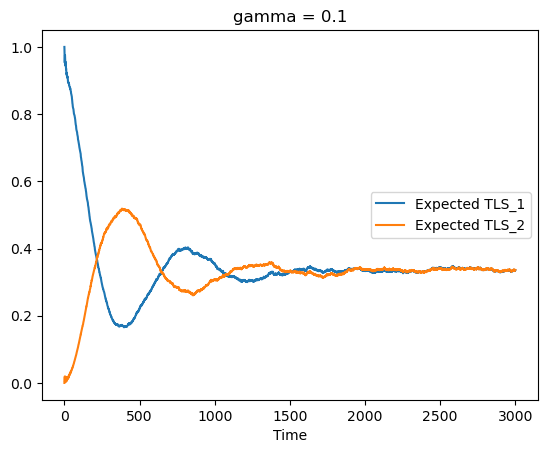

In [1205]:
plt.plot(times, data.expect[0], label="Expected TLS_1")
plt.plot(times, data.expect[1], label="Expected TLS_2")
plt.xlabel("Time")
plt.title("gamma = 0.1")
plt.legend(loc="right")

In [1043]:
times = np.linspace(0.0, 10.0, 200)
psi0 = tensor(fock(2, 0), fock(10, 8))
a  = tensor(qeye(2), destroy(10))
sm = tensor(destroy(2), qeye(10))
H = 2*np.pi*a.dag()*a + 2*np.pi*sm.dag()*sm + 2*np.pi*0.25*(sm*a.dag() + sm.dag()*a)
data = mcsolve(H, psi0, times, [np.sqrt(0.1) * a], e_ops=[a.dag() * a, sm.dag() * sm])

10.0%. Run time:   0.25s. Est. time left: 00:00:00:02
20.0%. Run time:   0.43s. Est. time left: 00:00:00:01
30.0%. Run time:   0.61s. Est. time left: 00:00:00:01
40.0%. Run time:   0.79s. Est. time left: 00:00:00:01
50.0%. Run time:   0.97s. Est. time left: 00:00:00:00
60.0%. Run time:   1.15s. Est. time left: 00:00:00:00
70.0%. Run time:   1.33s. Est. time left: 00:00:00:00
80.0%. Run time:   1.51s. Est. time left: 00:00:00:00
90.0%. Run time:   1.69s. Est. time left: 00:00:00:00
100.0%. Run time:   1.86s. Est. time left: 00:00:00:00
Total run time:   1.86s
